In [37]:
import QUANTAXIS as QA
try:
    assert QA.__version__>='1.0.45'
except AssertionError:
    print('pip install QUANTAXIS >= 1.0.45 请升级QUANTAXIS后再运行此示例')

In [2]:
print('首先确定你已经完成了对于QUANTAXIS的基础认知,以及在本地存储完毕了QUANTAXIS的数据库')

首先确定你已经完成了对于QUANTAXIS的基础认知,以及在本地存储完毕了QUANTAXIS的数据库


# QUANTAXIS 回测的一些基础知识

##  QA回测的核心是两个类

```
QA_BacktestBroker
QA_Account
```

##  回测数据的引入/迭代

```
QA.QA_fetch_stock_day_adv
QA.QA_fetch_stock_min_adv
```

##  指标的计算

```
DataStruct.add_func
```

##  对于账户的灵活运用

```
QA_Account
QA_Risk
QA_Portfolio
QA_PortfolioView
QA_User
```

## STEP1 初始化账户,初始化回测broker

In [3]:
Account=QA.QA_Account()
Broker=QA.QA_BacktestBroker()

In [4]:
# 打印账户的信息
try:
    from pprint import  pprint as print
except:
    pass
print(Account.message)

{'account_cookie': 'Acc_CgcMzSZD',
 'allow_sellopen': False,
 'allow_t0': False,
 'broker': 'backtest',
 'cash': [1000000],
 'commission_coeff': 0.00025,
 'current_time': None,
 'history': [],
 'init_assets': 1000000,
 'margin_level': False,
 'market_type': 'stock_cn',
 'portfolio_cookie': None,
 'running_time': datetime.datetime(2018, 6, 6, 13, 57, 58, 389135),
 'source': 'account',
 'strategy_name': None,
 'tax_coeff': 0.0015,
 'trade_index': [],
 'user_cookie': None}


## 首先讲解Account类:

QA_Account在初始化的时候,可以自己指定很多信息:

```
QA_Account(strategy_name=None, user_cookie=None, market_type=MARKET_TYPE.STOCK_CN, frequence=FREQUENCE.DAY,
                 broker=BROKER_TYPE.BACKETEST, portfolio_cookie=None, account_cookie=None,
                 sell_available={}, init_assets=None, cash=None, history=None, commission_coeff=0.00025, tax_coeff=0.0015,
                 margin_level=False, allow_t0=False, allow_sellopen=False)
                 
        :param strategy_name:  策略名称
        :param user_cookie:   用户cookie
        :param market_type:   市场类别 默认QA.MARKET_TYPE.STOCK_CN A股股票
        :param frequence:     账户级别 默认日线QA.FREQUENCE.DAY
        :param broker:        BROEKR类 默认回测 QA.BROKER_TYPE.BACKTEST
        :param portfolio_cookie: 组合cookie
        :param account_cookie:   账户cookie
        :param sell_available:   可卖股票数
        :param init_assets:       初始资产  默认 1000000 元 （100万）
        :param cash:              可用现金  默认 是 初始资产  list 类型
        :param history:           交易历史
        :param commission_coeff:  交易佣金 :默认 万2.5   float 类型
        :param tax_coeff:         印花税   :默认 千1.5   float 类型
        :param margin_level:      保证金比例 默认False
        :param allow_t0:          是否允许t+0交易  默认False
        :param allow_sellopen:    是否允许卖空开仓  默认False
```

In [5]:
# 重设账户初始资金

Account.reset_assets(200000)
Account.account_cookie='JCSC_EXAMPLE'

In [6]:
Account.init_assets

200000

Account 有很多方法,暂时不详细展开,我们先直接进入下一步

# SETP2:引入回测的市场数据

引入方法非常简单,直接使用QA_fetch_stock_day_adv系列即可

- code 可以是多种多样的选取方式

```python
1. QA.QA_fetch_stock_list_adv().code.tolist() # 获取全市场的股票代码
2. QA.QA_fetch_stock_block_adv().get_block('云计算').code  # 按版块选取
3. code= ['000001','000002'] # 自己指定
```
- 数据获取后,to_qfq() 即可获得前复权数据

```python
data=DataSturct.to_qfq()
```

In [7]:
# QA.QA_fetch_stock_list_adv().code.tolist()
# QA.QA_fetch_stock_block_adv().get_block('云计算').code


In [8]:
data=QA.QA_fetch_stock_day_adv(['000001','000002','000004','600000'],'2017-09-01','2018-05-20')

In [9]:
data

< QA_DataStruct_Stock_day with 4 securities >

In [10]:
data=data.to_qfq()

In [11]:
# data.data

## STEP3:计算一些指标

指标的计算可以在回测前,也可以在回测中进行

回测前的计算则是批量计算,效率较高

回测中的计算,效率略低,但代码量较小,易于理解

PS: 指标的相关介绍参见 [QUANTAXIS的指标系统](https://github.com/QUANTAXIS/QUANTAXIS/blob/master/Documents/indicators.md)

In [12]:
import numpy as np
import pandas as pd
def MACD_JCSC(dataframe,SHORT=12,LONG=26,M=9):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    CLOSE=dataframe.close
    DIFF =QA.EMA(CLOSE,SHORT) - QA.EMA(CLOSE,LONG)
    DEA = QA.EMA(DIFF,M)
    MACD =2*(DIFF-DEA)

    CROSS_JC=QA.CROSS(DIFF,DEA)
    CROSS_SC=QA.CROSS(DEA,DIFF)
    ZERO=0
    return pd.DataFrame({'DIFF':DIFF,'DEA':DEA,'MACD':MACD,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC,'ZERO':ZERO})

In [13]:
ind=data.add_func(MACD_JCSC)

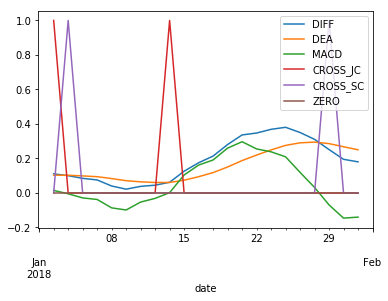

In [14]:
ind.xs('000001',level=1)['2018-01'].plot()

In [15]:
ind.xs('000001',level=1)['2018-01']

,DIFF,DEA,MACD,CROSS_JC,CROSS_SC,ZERO
date,,,,,,
2018-01-02,0.110686,0.103225,0.014921,1,0,0
2018-01-03,0.100387,0.102657,-0.004541,0,1,0
2018-01-04,0.084801,0.099086,-0.028570,0,0,0
2018-01-05,0.075607,0.094390,-0.037566,0,0,0
2018-01-08,0.040453,0.083603,-0.086299,0,0,0
2018-01-09,0.022012,0.071285,-0.098545,0,0,0
2018-01-10,0.038391,0.064706,-0.052629,0,0,0
2018-01-11,0.045208,0.060806,-0.031197,0,0,0
2018-01-12,0.061988,0.061043,0.001890,1,0,0


In [16]:
ind.loc['2018-01',slice(None)]

DIFF       DEA      MACD  CROSS_JC  CROSS_SC  ZERO
date       code                                                          
2018-01-02 000001  0.110686  0.103225  0.014921         1         0     0
           000002  0.404554  0.189272  0.430564         0         0     0
           000004 -0.717479 -0.746157  0.057357         0         0     0
           600000 -0.062653 -0.054428 -0.016450         0         0     0
2018-01-03 000001  0.100387  0.102657 -0.004541         0         1     0
           000002  0.511649  0.253747  0.515803         0         0     0
           000004 -0.567604 -0.710447  0.285686         0         0     0
           600000 -0.058690 -0.055280 -0.006820         0         0     0
2018-01-04 000001  0.084801  0.099086 -0.028570         0         0     0
           000002  0.652650  0.333528  0.638244         0         0     0
           000004 -0.488320 -0.666021  0.355402         0         0     0
           600000 -0.054916 -0.055207  0.000582         1         0     0
2018-01-05 000001  0.075607  0.094390 -0.037566         0         0     0
           000002  0.886331  0.444089  0.884484         0         0     0
           000004 -0.425418 -0.617901  0.384965         0         0     0
           600000 -0.048944 -0.053955  0.010022         0         0     0
2018-01-08 000001  0.040453  0.083603 -0.086299         0         0     0
           000002  1.157306  0.586732  1.141148         0         0     0
           000004 -0.398377 -0.573996  0.351238         0         0     0
           600000 -0.044503 -0.052064  0.015122         0         0     0
2018-01-09 000001  0.022012  0.071285 -0.098545         0         0     0
           000002  1.344462  0.738278  1.212368         0         0     0
           000004 -0.358308 -0.530858  0.345101         0         0     0
           600000 -0.038924 -0.049436  0.021025         0         0     0
2018-01-10 000001  0.038391  0.064706 -0.052629         0         0     0
           000002  1.462222  0.883067  1.158309         0         0     0
           000004 -0.372237 -0.499134  0.253794         0         0     0
           600000 -0.008609 -0.041271  0.065324         0         0     0
2018-01-11 000001  0.045208  0.060806 -0.031197         0         0     0
           000002  1.496376  1.005729  0.981293         0         0     0
...                     ...       ...       ...       ...       ...   ...
2018-01-22 000004 -0.541106 -0.511879 -0.058454         0         0     0
           600000  0.078336  0.049190  0.058291         0         0     0
2018-01-23 000001  0.368907  0.249605  0.238603         0         0     0
           000002  2.535276  2.079891  0.910770         0         0     0
           000004 -0.526304 -0.514764 -0.023080         0         0     0
           600000  0.068875  0.053127  0.031496         0         0     0
2018-01-24 000001  0.380702  0.275825  0.209755         0         0     0
           000002  2.600984  2.184110  0.833749         0         0     0
           000004 -0.474423 -0.506696  0.064544         1         0     0
           600000  0.114099  0.065322  0.097555         0         0     0
2018-01-25 000001  0.350521  0.290764  0.119515         0         0     0
           000002  2.548667  2.257021  0.583292         0         0     0
           000004 -0.453885 -0.496134  0.084496         0         0     0
           600000  0.154610  0.083179  0.142861         0         0     0
2018-01-26 000001  0.310920  0.294795  0.032249         0         0     0
           000002  2.465873  2.298792  0.334164         0         0     0
           000004 -0.442190 -0.485345  0.086310         0         0     0
           600000  0.165449  0.099633  0.131632         0         0     0
2018-01-29 000001  0.251630  0.286162 -0.069064         0         1     0
           000002  2.255685  2.290170 -0.068970         0         1     0
           000004 -0.448720 -0.478020  0.058599         0         0     0
           600000  0.176043

# SETP4:选取回测的开始和结束日期,构建回测

In [17]:
data_forbacktest=data.select_time('2018-01-01','2018-05-01')


for items in data_forbacktest.panel_gen:
    for item in items.security_gen:
        daily_ind=ind.loc[item.index]
        if daily_ind.CROSS_JC.iloc[0]>0:
            order=Account.send_order(
                code=item.data.code[0], 
                time=item.data.date[0], 
                amount=1000, 
                towards=QA.ORDER_DIRECTION.BUY, 
                price=0, 
                order_model=QA.ORDER_MODEL.CLOSE, 
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )
            Account.receive_deal(Broker.receive_order(QA.QA_Event(order=order,market_data=item)))
        elif daily_ind.CROSS_SC.iloc[0]>0:
            if Account.sell_available.get(item.code[0], 0)>0:
                order=Account.send_order(
                    code=item.data.code[0], 
                    time=item.data.date[0], 
                    amount=Account.sell_available.get(item.code[0], 0), 
                    towards=QA.ORDER_DIRECTION.SELL, 
                    price=0, 
                    order_model=QA.ORDER_MODEL.MARKET, 
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                Account.receive_deal(Broker.receive_order(QA.QA_Event(order=order,market_data=item)))
    Account.settle()
            
        #break

## STEP5: 分析账户

In [18]:
Account.history

[['2018-01-02 15:00:00',
  '000001',
  13.7,
  1000.0,
  'Order_eJFI3mwU',
  'Trade_4rcWX3PS',
  'JCSC_EXAMPLE',
  5.0,
  0.0],
 ['2018-01-03 09:30:00',
  '000001',
  13.53,
  -1000.0,
  'Order_Qxc4Mboq',
  'Trade_yVUrBc4g',
  'JCSC_EXAMPLE',
  5.0,
  20.295],
 ['2018-01-04 15:00:00',
  '600000',
  12.66,
  1000.0,
  'Order_ETydAzu6',
  'Trade_8y9dKuJc',
  'JCSC_EXAMPLE',
  5.0,
  0.0],
 ['2018-01-12 15:00:00',
  '000001',
  13.55,
  1000.0,
  'Order_Qgns5xvq',
  'Trade_tUu08RE2',
  'JCSC_EXAMPLE',
  5.0,
  0.0],
 ['2018-01-24 15:00:00',
  '000004',
  22.08,
  1000.0,
  'Order_xDeQcwGY',
  'Trade_fuE3mx4g',
  'JCSC_EXAMPLE',
  5.52,
  0.0],
 ['2018-01-29 09:30:00',
  '000001',
  13.93,
  -1000.0,
  'Order_EVhsUR0D',
  'Trade_G3UQJiSx',
  'JCSC_EXAMPLE',
  5.0,
  20.8875],
 ['2018-01-31 09:30:00',
  '000004',
  20.73,
  -1000.0,
  'Order_dKPcMH5R',
  'Trade_MyRfepw0',
  'JCSC_EXAMPLE',
  5.18375,
  31.1025],
 ['2018-02-02 09:30:00',
  '600000',
  13.1,
  -1000.0,
  'Order_RE4l1ZvW',
  '

In [19]:
Account.history_table

,datetime,code,price,amount,order_id,trade_id,account_cookie,commission,tax
0,2018-01-02 15:00:00,000001,13.70,1000.0,Order_eJFI3mwU,Trade_4rcWX3PS,JCSC_EXAMPLE,5.00000,0.0000
1,2018-01-03 09:30:00,000001,13.53,-1000.0,Order_Qxc4Mboq,Trade_yVUrBc4g,JCSC_EXAMPLE,5.00000,20.2950
2,2018-01-04 15:00:00,600000,12.66,1000.0,Order_ETydAzu6,Trade_8y9dKuJc,JCSC_EXAMPLE,5.00000,0.0000
3,2018-01-12 15:00:00,000001,13.55,1000.0,Order_Qgns5xvq,Trade_tUu08RE2,JCSC_EXAMPLE,5.00000,0.0000
4,2018-01-24 15:00:00,000004,22.08,1000.0,Order_xDeQcwGY,Trade_fuE3mx4g,JCSC_EXAMPLE,5.52000,0.0000
5,2018-01-29 09:30:00,000001,13.93,-1000.0,Order_EVhsUR0D,Trade_G3UQJiSx,JCSC_EXAMPLE,5.00000,20.8875
6,2018-01-31 09:30:00,000004,20.73,-1000.0,Order_dKPcMH5R,Trade_MyRfepw0,JCSC_EXAMPLE,5.18375,31.1025
7,2018-02-02 09:30:00,600000,13.10,-1000.0,Order_RE4l1ZvW,Trade_18MjFeYl,JCSC_EXAMPLE,5.00000,19.6500
8,2018-02-05 15:00:00,600000,13.49,1000.0,Order_crPzt1EF,Trade_3g1vTaoK,JCSC_EXAMPLE,5.00000,0.0000
9,2018-02-08 09:30:00,600000,13.18,-1000.0,Order_KU6dzHiW,Trade_bQmzWVvx,JCSC_EXAMPLE,5.00000,19.7625


In [20]:
Account.daily_hold

,code,000001,000002,000004,600000
date,account_cookie,,,,
2018-01-02,JCSC_EXAMPLE,1000.0,0.0,0.0,0.0
2018-01-03,JCSC_EXAMPLE,0.0,0.0,0.0,0.0
2018-01-04,JCSC_EXAMPLE,0.0,0.0,0.0,1000.0
2018-01-12,JCSC_EXAMPLE,1000.0,0.0,0.0,1000.0
2018-01-24,JCSC_EXAMPLE,1000.0,0.0,1000.0,1000.0
2018-01-29,JCSC_EXAMPLE,0.0,0.0,1000.0,1000.0
2018-01-31,JCSC_EXAMPLE,0.0,0.0,0.0,1000.0
2018-02-02,JCSC_EXAMPLE,0.0,0.0,0.0,0.0
2018-02-05,JCSC_EXAMPLE,0.0,0.0,0.0,1000.0


In [21]:
Risk=QA.QA_Risk(Account)

In [22]:
Risk.message

{'account_cookie': 'JCSC_EXAMPLE',
 'portfolio_cookie': None,
 'user_cookie': None,
 'annualize_return': -0.11,
 'profit': -0.03,
 'max_dropback': 0.04,
 'time_gap': 68,
 'volatility': 0.09,
 'benchmark_code': '000300',
 'bm_annualizereturn': -0.17,
 'bn_profit': -0.05,
 'beta': 1.0,
 'alpha': 0.06,
 'sharpe': -1.78,
 'init_assets': '200000.00',
 'last_assets': '194100.07'}

In [23]:
Risk.assets

date
2018-01-02    199995.00000
2018-01-03    199799.70500
2018-01-04    199794.70500
2018-01-12    200039.70500
2018-01-24    201784.18500
2018-01-29    200238.29750
2018-01-31    199262.01125
2018-02-02    199167.36125
2018-02-05    199162.36125
2018-02-08    198827.59875
2018-02-13    198822.57375
2018-03-08    199709.16375
2018-03-19    199583.07625
2018-03-26    198761.53125
2018-03-29    198712.99125
2018-04-02    197943.25750
2018-04-10    196628.25750
2018-04-11    197463.25750
2018-04-16    194100.06625
Name: 0, dtype: float64

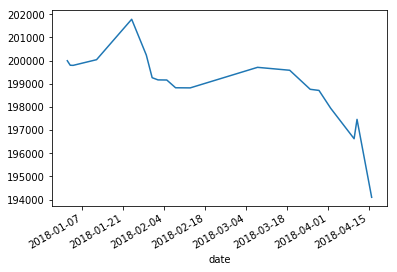

In [24]:
Risk.assets.plot()

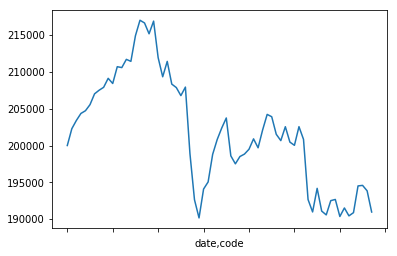

In [30]:
Risk.benchmark_assets.plot()

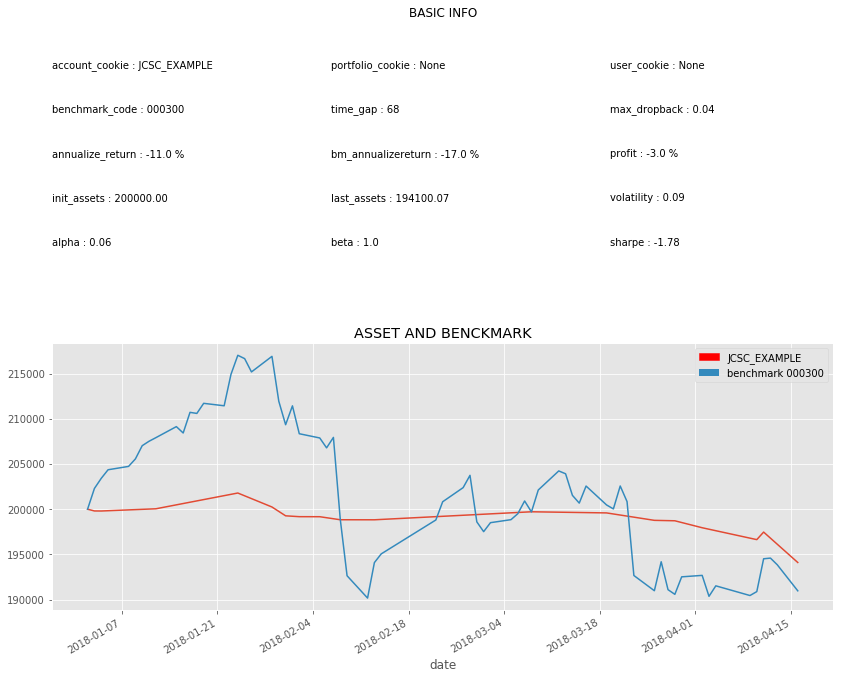

In [32]:
Risk.plot_assets_curve()

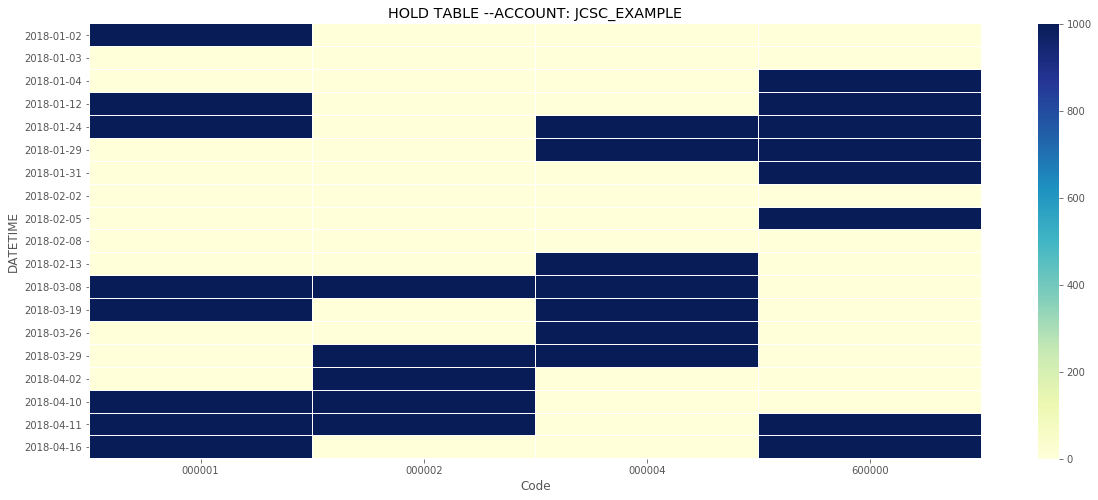

In [34]:
Risk.plot_dailyhold()

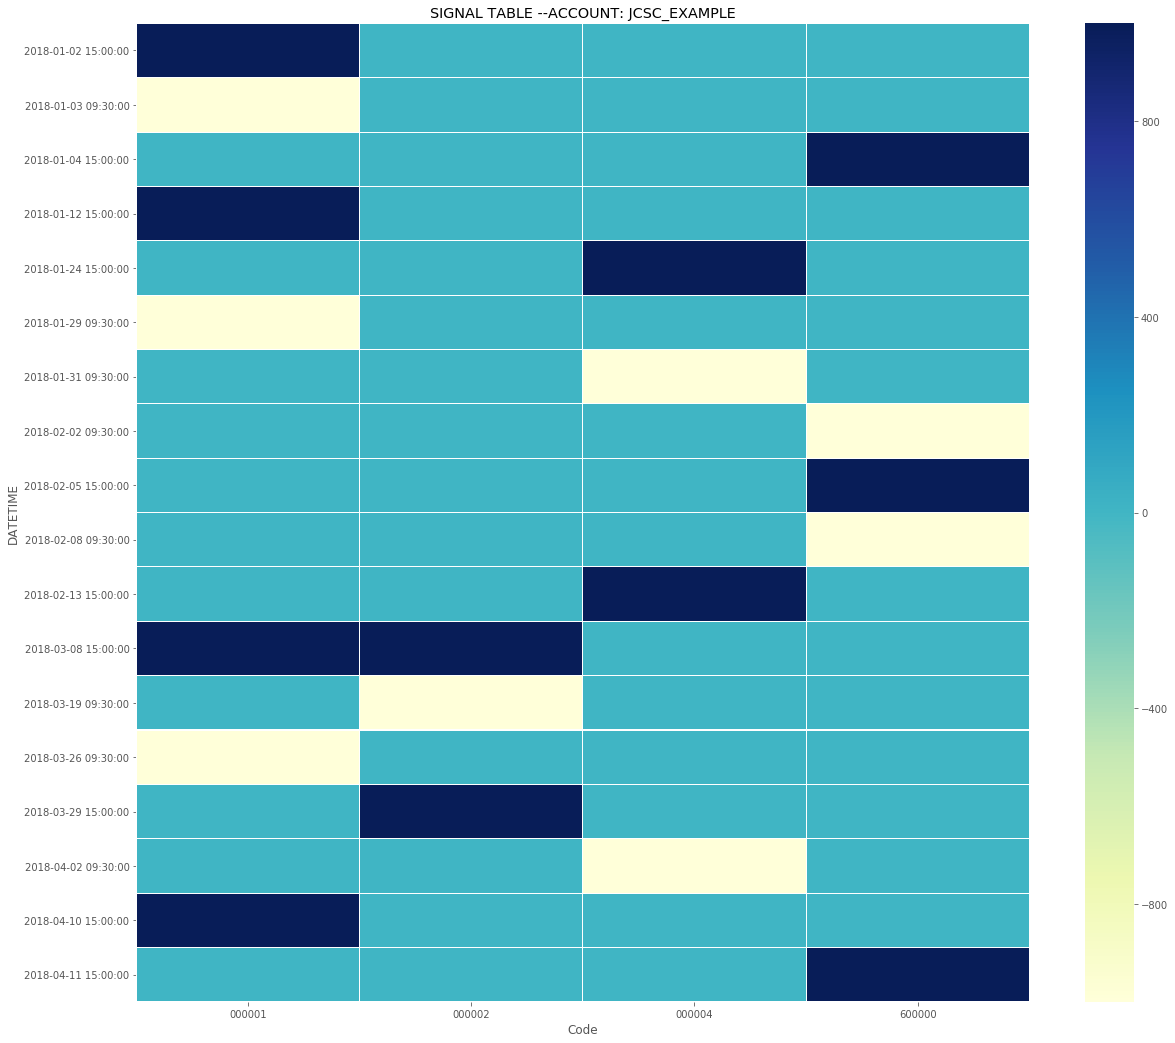

In [36]:
Risk.plot_signal()

In [39]:
Performance=QA.QA_Performance(Account)

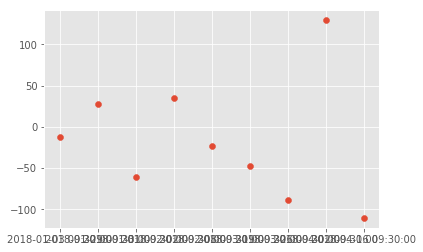

In [41]:
Performance.plot_pnlmoney(Performance.pnl_fifo)

## STEP6: 存储结果

In [26]:
Account.save()
Risk.save()

## STEP7: 查看存储的结果

In [27]:
account_info=QA.QA_fetch_account({'account_cookie':'JCSC_EXAMPLE'})

In [28]:
account=QA.QA_Account().from_message(account_info[0])

In [29]:
account

< QA_Account JCSC_EXAMPLE>